In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import numpy as np
import itertools


In [16]:
data = pd.read_csv('music_data_model.csv')

In [17]:
cols = ['name',
       'danceability', 'energy', 'key_', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'number_sections', 'avg_duration',
       'std_duration', 'std_loudness', 'std_tempo', 'number_keys']
df1 = data[cols]

In [57]:
df1.dropna(inplace=True)

In [66]:
X = df1.drop('name', axis=1)
y = df1['name']


In [67]:
X['key_'] = X['key_'].astype('category')

In [68]:
X.dtypes

danceability         float64
energy               float64
key_                category
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms          float64
time_signature       float64
number_sections        int64
avg_duration         float64
std_duration         float64
std_loudness         float64
std_tempo            float64
number_keys          float64
dtype: object

In [69]:
data = pd.get_dummies(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size= .25, random_state = 123)

## Create Base Model

In [71]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)

preds = dummy_clf.predict(X_test)
confusion_matrix(y_test, preds)

array([[19, 18, 16,  9, 10, 11,  9],
       [25, 21, 13,  4,  6,  8, 21],
       [12, 16,  2,  4,  2,  6, 10],
       [ 8,  8,  2,  1,  1,  6,  4],
       [ 1,  8,  3,  2,  3,  2,  2],
       [ 8,  9,  3,  3,  3,  3, 12],
       [11, 20,  6,  8,  4,  9, 18]])

In [72]:
accuracy_score(y_test, preds)

0.16341463414634147

## Fit initial Random Forest Classifier without any hyperparameter tuning

In [73]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [74]:
forest.score(X_train, y_train)

0.7263843648208469

In [79]:
y_preds = forest.predict(X_test)

In [75]:
forest.score(X_test, y_test)

0.6780487804878049

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[59 26  0  0  1  1  5]
 [11 80  0  0  0  2  5]
 [ 0  0 48  2  0  1  1]
 [ 5  2 10 11  1  1  0]
 [ 1  1 15  2  1  0  1]
 [ 4  5  2  0  0 24  6]
 [ 6 13  0  0  0  2 55]]
                       precision    recall  f1-score   support

    Bruce Springsteen       0.69      0.64      0.66        92
        Fleetwood Mac       0.63      0.82      0.71        98
                JAY-Z       0.64      0.92      0.76        52
           Kanye West       0.73      0.37      0.49        30
       Kendrick Lamar       0.33      0.05      0.08        21
Red Hot Chili Peppers       0.77      0.59      0.67        41
   The Rolling Stones       0.75      0.72      0.74        76

             accuracy                           0.68       410
            macro avg       0.65      0.59      0.59       410
         weighted avg       0.67      0.68      0.66       410



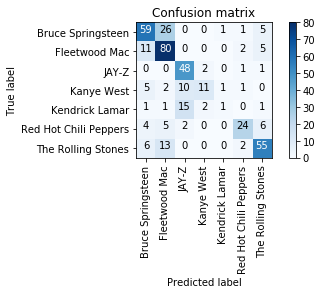

In [95]:
cm = confusion_matrix(y_test, y_preds)
classes = ['Bruce Springsteen', 'Fleetwood Mac','JAY-Z',
       'Kanye West','Kendrick Lamar' , 'Red Hot Chili Peppers',
       'The Rolling Stones']
plot_confusion_matrix(cm, classes)
print(classification_report(y_test, y_preds))

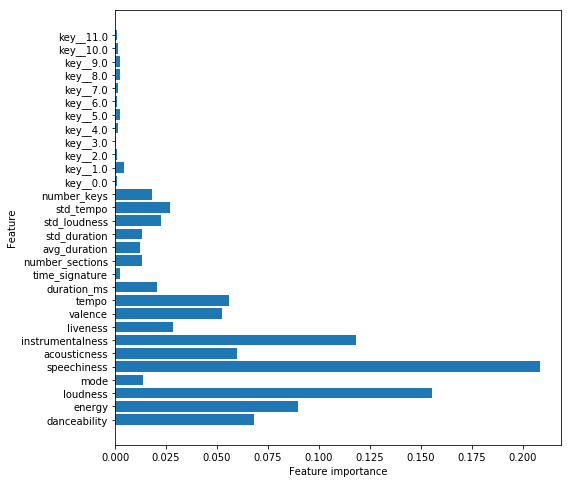

In [99]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest)

## Re-run Random Forest with hyperparameter tuning

In [103]:
rf_mean_cv_score_train = np.mean(cross_val_score(forest, X_train, y_train))
rf_mean_cv_score_train

/Users/marshall132/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.5928913636652072

In [161]:
rf_param_grid = {'n_estimators' : [20, 40, 60, 80, 100, 120, 150,200],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1,3,5,7],
                'min_samples_split' : [5,10,15,20],
                 'max_features' : ['sqrt','log2'],
                'min_samples_leaf': [5, 10, 20]}
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=5)

rf_grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(f"Training Accuracy: {rf_grid_search.best_score_}")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

## Run another gridsearch using parameters close to the optimal values from the first one

In [111]:
rf2_param_grid = {'n_estimators' : [18,19,20,21,22],
                'criterion' : 'entropy',
                'max_depth' : [7,9,11,13,15],
                'min_samples_split' : [8,9,10,11,12],
                'min_samples_leaf': [1,3,5,7]}
rf2_grid_search = GridSearchCV(forest, rf_param_grid, cv=5)

rf2_grid_search.fit(X_train, y_train)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn

In [112]:
print(f"Training Accuracy: {rf2_grid_search.best_score_}")
print(f"Optimal Parameters: {rf2_grid_search.best_params_}")

Training Accuracy: 0.6188925081433225
Optimal Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 18}


### There is no improvement in model performance after further model tuning. Now let's see how these new parameters affect our test data

In [115]:
forest2 = RandomForestClassifier(criterion='entropy',
                                 max_depth= 7,
                                 min_samples_leaf= 5,
                                 min_samples_split= 10,
                                 n_estimators=18
                                )
forest2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [116]:
forest2.score(X_train, y_train)

0.8135179153094463

In [117]:
preds2 = forest2.predict(X_test)
accuracy_score(y_test, preds2)

0.675609756097561

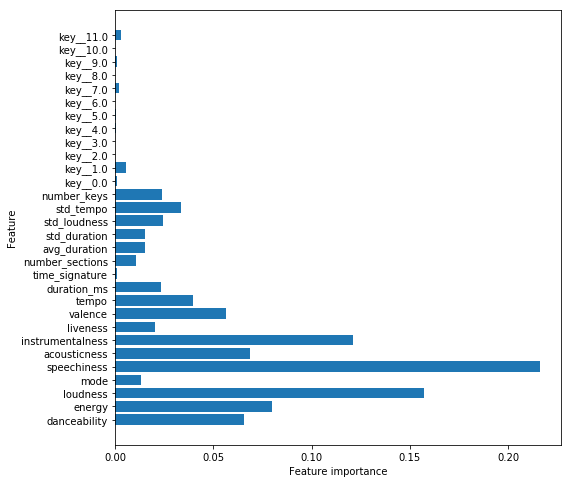

In [118]:
plot_feature_importances(forest2)

Confusion Matrix, without normalization
[[60 22  0  1  0  1  8]
 [15 77  0  1  0  1  4]
 [ 2  0 45  4  0  0  1]
 [ 4  2  8 12  2  2  0]
 [ 0  1 13  4  3  0  0]
 [ 2  4  3  0  0 26  6]
 [ 8 11  0  0  0  3 54]]
                       precision    recall  f1-score   support

    Bruce Springsteen       0.69      0.64      0.66        92
        Fleetwood Mac       0.63      0.82      0.71        98
                JAY-Z       0.64      0.92      0.76        52
           Kanye West       0.73      0.37      0.49        30
       Kendrick Lamar       0.33      0.05      0.08        21
Red Hot Chili Peppers       0.77      0.59      0.67        41
   The Rolling Stones       0.75      0.72      0.74        76

             accuracy                           0.68       410
            macro avg       0.65      0.59      0.59       410
         weighted avg       0.67      0.68      0.66       410



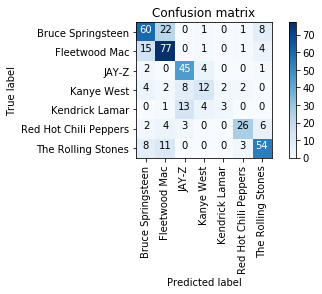

In [121]:
cm = confusion_matrix(y_test, preds2)
classes = ['Bruce Springsteen', 'Fleetwood Mac','JAY-Z',
       'Kanye West','Kendrick Lamar' , 'Red Hot Chili Peppers',
       'The Rolling Stones']
plot_confusion_matrix(cm, classes)
print(classification_report(y_test, y_preds))

#### Test model performance did not improve when using the optimized features from the grid search, even though the training score improved significantly. 

## Now let's try a few weak learning methods, Adaboost and Gradientboost, to see if other techniques impove model performance

In [125]:
adaboost_clf = AdaBoostClassifier(random_state = 42)

In [126]:
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

#### Not looking so good for Adaboost...

In [ ]:
y_preds = adaboost_clf.predict(X_test)
accuracy_score(y_test, y_preds)

#### We might have some hope with Gradientboost!

In [149]:
gbt_clf = GradientBoostingClassifier(random_state=42)#random_state = 42)
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [151]:
preds = gbt_clf.predict(X_test)
accuracy_score(y_test, preds)


0.7073170731707317

#### However this model is overfit to the training data

In [152]:
gbt_clf.score(X_train, y_train)

0.992671009771987

### Maybe we can improve model performance through hyperparameter tuning and cross validation

In [169]:
grid = {'learning_rate' : [.05,.075,.1],
       'n_estimators' : [120,140, 160, 180, 200],
       'max_depth': [1,3,5]
       }
gs = GridSearchCV(gbt_clf, grid, cv=5)

gs.fit(X_train, y_train)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=120,
                                                  n_iter_no_change=None,
                                                  presort=

In [170]:
print(f"Training Accuracy: {gs.best_score_}")
print(f"Optimal Parameters: {gs.best_params_}")

Training Accuracy: 0.6815960912052117
Optimal Parameters: {'learning_rate': 0.075, 'max_depth': 5, 'n_estimators': 160}


In [166]:
gbt_clf2 = GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=120)#random_state = 42)
gbt_clf2.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [167]:
preds = gbt_clf2.predict(X_test)
accuracy_score(y_test, preds)

0.7073170731707317